#### Сайт запустил A/B тест с целью увеличения дохода. Файл AB_Test_Results.csvl содержит необработанные данные о результатах эксперимента.
Задача — проанализировать результаты эксперимента и написать свои рекомендации.

In [37]:
import pandas as pd
import numpy as np
import seaborn as sns

import matplotlib.pyplot as plt

from tqdm.auto import tqdm
from scipy.stats import norm


%matplotlib inline 

In [38]:
dt = pd.read_csv('AB_Test_Results.csv', encoding='windows-1251', sep=',')


In [39]:
dt

,USER_ID,VARIANT_NAME,REVENUE
0,737,variant,0.0
1,2423,control,0.0
2,9411,control,0.0
3,7311,control,0.0
4,6174,variant,0.0
...,...,...,...
9995,1981,control,0.0
9996,502,variant,0.0
9997,9214,variant,0.0
9998,7741,control,0.0


In [40]:
metrics = dt.groupby('VARIANT_NAME',as_index = False).agg({'REVENUE':'sum',
                                                          'USER_ID' : 'count'})
metrics['conversion'] = metrics['REVENUE']/metrics['USER_ID']*100
metrics

,VARIANT_NAME,REVENUE,USER_ID,conversion
0,control,643.00,4984,12.901284
1,variant,351.47,5016,7.006978


Конверсия в контрольной группе значительно превышает конверсию в тестовой. 

#### Проверим 2 гипотезы:

> Н0 : M control = M variant (среднее значение контрльной группы не отличается от среднего значения тестовой группы)

> Н1 : M control ≠ M variant (отличие в средних значениях этих групп есть)

In [41]:
def get_bootstrap(
    data_column_1, # числовые значения первой выборки
    data_column_2, # числовые значения второй выборки
    boot_it = 1000, # количество бутстрэп-подвыборок
    statistic = np.mean, # интересующая нас статистика
    bootstrap_conf_level = 0.95 # уровень значимости
):
    boot_len = max([len(data_column_1), len(data_column_2)])
    boot_data = []
    for i in tqdm(range(boot_it)): # извлекаем подвыборки
        samples_1 = data_column_1.sample(
            boot_len, 
            replace = True # параметр возвращения
        ).values
        
        samples_2 = data_column_2.sample(
            boot_len, # чтобы сохранить дисперсию, берем такой же размер выборки
            replace = True
        ).values
        
        boot_data.append(statistic(samples_1-samples_2)) 
    pd_boot_data = pd.DataFrame(boot_data)
        
    left_quant = (1 - bootstrap_conf_level)/2
    right_quant = 1 - (1 - bootstrap_conf_level) / 2
    quants = pd_boot_data.quantile([left_quant, right_quant])
        
    p_1 = norm.cdf(
        x = 0, 
        loc = np.mean(boot_data), 
        scale = np.std(boot_data)
    )
    p_2 = norm.cdf(
        x = 0, 
        loc = -np.mean(boot_data), 
        scale = np.std(boot_data)
    )
    p_value = min(p_1, p_2) * 2
        
    # Визуализация
    _, _, bars = plt.hist(pd_boot_data[0], bins = 50)
    for bar in bars:
        if abs(bar.get_x()) <= quants.iloc[0][0] or abs(bar.get_x()) >= quants.iloc[1][0]:
            bar.set_facecolor('red')
        else: 
            bar.set_facecolor('grey')
            bar.set_edgecolor('black')
    
    plt.style.use('ggplot')
    plt.vlines(quants,ymin=0,ymax=50,linestyle='--')
    plt.xlabel('boot_data')
    plt.ylabel('frequency')
    plt.title("Histogram of boot_data")
    plt.show()
       
    return {"boot_data": boot_data, 
            "quants": quants, 
            "p_value": p_value}

In [42]:
# будем пробовать бутстрап на эксп. распределении
np.random.seed(5)

In [43]:
n = 1000

sample_1 = np.random.exponential(scale=1/0.001, size=n)
sample_2 = np.random.exponential(scale=1/0.00101, size=n)

df = pd.DataFrame({
    "sample_1": sample_1,
    "sample_2": sample_2
})

  0%|          | 0/1000 [00:00<?, ?it/s]

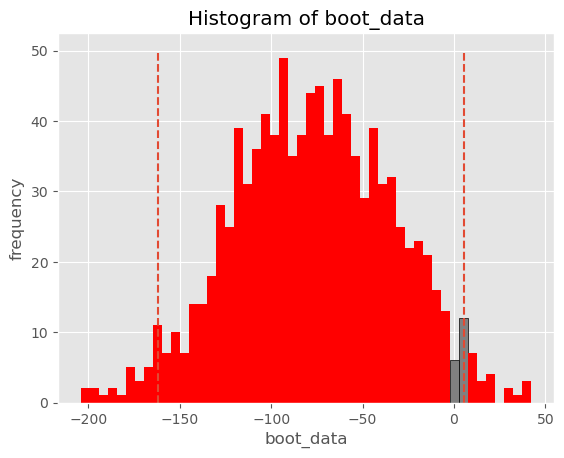

In [44]:
booted_data = get_bootstrap(df.sample_1, df.sample_2) # в результате хранится разница двух распределений, ДИ и pvalue

In [45]:
dt.groupby('VARIANT_NAME',as_index = False).agg({'REVENUE': 'count'})

,VARIANT_NAME,REVENUE
0,control,4984
1,variant,5016


In [46]:
dt.groupby('VARIANT_NAME',as_index = False).agg({'REVENUE': 'mean'})

,VARIANT_NAME,REVENUE
0,control,0.129013
1,variant,0.070070


In [47]:
dt.groupby('VARIANT_NAME',as_index = False).agg({'REVENUE': 'median'})

,VARIANT_NAME,REVENUE
0,control,0.0
1,variant,0.0


  0%|          | 0/1000 [00:00<?, ?it/s]

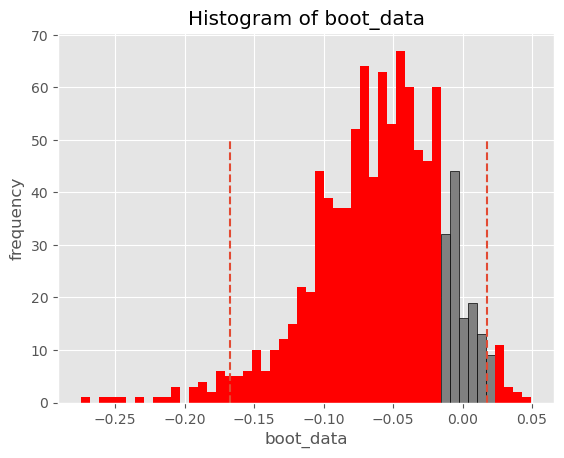

{'boot_data': [-0.10059609250398724,
  -0.1007675438596491,
  -0.07543460925039873,
  -0.060522328548644345,
  -0.013241626794258374,
  -0.10110645933014353,
  -0.07186204146730463,
  -0.10152910685805422,
  -0.036656698564593304,
  -0.019274322169059013,
  -0.0454884370015949,
  -0.10509768740031897,
  -0.08138556618819777,
  -0.0004385964912280679,
  -0.021576953748006382,
  -0.08813397129186602,
  0.006692583732057412,
  -0.04858851674641148,
  -0.0500518341307815,
  -0.07127990430622008,
  -0.06941188197767145,
  -0.035655901116427434,
  0.01102671451355662,
  -0.02081738437001595,
  -0.1262061403508772,
  -0.1514413875598086,
  -0.03421850079744816,
  0.008401116427432216,
  -0.10766746411483252,
  -0.07050039872408295,
  -0.09168660287081339,
  -0.060111642743221685,
  -0.027165071770334927,
  -0.023712121212121212,
  -0.02966307814992026,
  0.0009250398724082865,
  -0.018373205741626795,
  -0.016381578947368428,
  -0.08160287081339712,
  -0.05719497607655502,
  -0.05279904306220

In [48]:
get_bootstrap(
    dt[dt.VARIANT_NAME == 'variant'].REVENUE, # числовые значения первой выборки
    dt[dt.VARIANT_NAME == 'control'].REVENUE, # числовые значения второй выборки
    boot_it = 1000, # количество бутстрэп-подвыборок
    statistic = np.mean, # интересующая нас статистика
    bootstrap_conf_level = 0.95 # уровень значимости
)

#### Вывод: p_value =   0.193 > 0.05
мы не можем отклонить Н0. Среднее значение контрольной группы значимо не отличается от среднего значения тестовой группы. 